In [1]:
# Script for Fig.2: Internal variability
# Author: Xin Zhou
# Time : 2022-07-20
# %%
import datetime
from turtle import color
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr

In [2]:
params = {'legend.fontsize':12,
         'axes.labelsize':17,
         'axes.titlesize':22,
         'xtick.labelsize':17,
         'ytick.labelsize':17}
plt.rcParams.update(params)

factorQ=10**6*(1/0.62199) #tansfer unit from kg/kg to ppmv

def error_delta(var0,var1,N):
    sqN=1/np.sqrt(N)
    error0 = var0.std('realization')
    error0_Squarred = np.multiply(error0,error0)
    error1 = var1.std('realization')
    error = np.sqrt(np.multiply(error1,error1)+error0_Squarred)*sqN
    return error

def plot_T_WV_couplet(Dates,cptt,cptt_error,RH,RH_error,label_str):
    fig,axes=plt.subplots(2,1,figsize=[5,5])
    axes = np.ravel(axes)
    plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
    fig.autofmt_xdate()
    labelsizes='17'
    for i in range(3):
        axes[0].plot(Dates,cptt[i],linewidth=2.0,label=label_str[i])
        axes[0].fill_between(Dates,  (cptt[i]+cptt_error[i]), (cptt[i]-cptt_error[i]),alpha=0.3)
       
    # axes[0].set_title('$\Delta$ cold point temperature \n [-5,5]° latitude',fontsize=titlesizes)
    axes[0].set_ylabel('$\Delta$ cold point temperature \n [K]',fontsize=labelsizes)

    for i in range(3):
        axes[1].plot(Dates,RH[i]*factorQ,linewidth=2.0,label=label_str[i])
        axes[1].fill_between(Dates,  (factorQ*(RH[i]+RH_error[i])), factorQ*((RH[i]-RH_error[i])),alpha=0.3)
    
    # axes[1].set_title('$\Delta$ specific humidity at 100 hPa \n [-5,5]° latitude',fontsize=titlesizes)
    axes[1].set_ylabel('$\Delta$ specific humidity at 100 hPa \n [ppmv]',fontsize=labelsizes)

    for i in range(np.shape(axes)[0]):
        axes[i].grid(True)
        axes[i].axvline(x=datetime.date(1991,6,15),color='blue',label='volcanic eruption')
        axes[i].tick_params(axis='both', which='major', labelsize=labelsizes)
        axes[i].set_xlabel('time',fontsize=labelsizes)
        axes[i].legend(fontsize=labelsizes,bbox_to_anchor=[1, 0.8])
    return fig,axes

def bootstrap(x,y):
    # set number of bootstrap samples
    n_bootstrap = 200

    # create empty array to hold bootstrap samples
    bootstrap_diffs = np.empty(n_bootstrap)

    # perform bootstrapping
    for i in range(n_bootstrap):
        # resample x and y with replacement
        x_resampled = x[np.random.choice(len(x), len(x), replace=True)]
        y_resampled = y[np.random.choice(len(y), len(y), replace=True)]
        
        # compute mean of each resampled array
        x_resampled_mean = np.nanmean(x_resampled)
        y_resampled_mean = np.nanmean(y_resampled)
        
        # compute percent difference between means
        bootstrap_diffs[i] = abs(x_resampled_mean - y_resampled_mean) / ((x_resampled_mean + y_resampled_mean) / 2) * 100

        # compute standard deviation of bootstrap samples
        percent_diff_uncertainty = np.std(bootstrap_diffs)

        #print(f"Percent difference: {percent_diff:.2f}% ± {percent_diff_uncertainty:.2f}%")
        return percent_diff_uncertainty

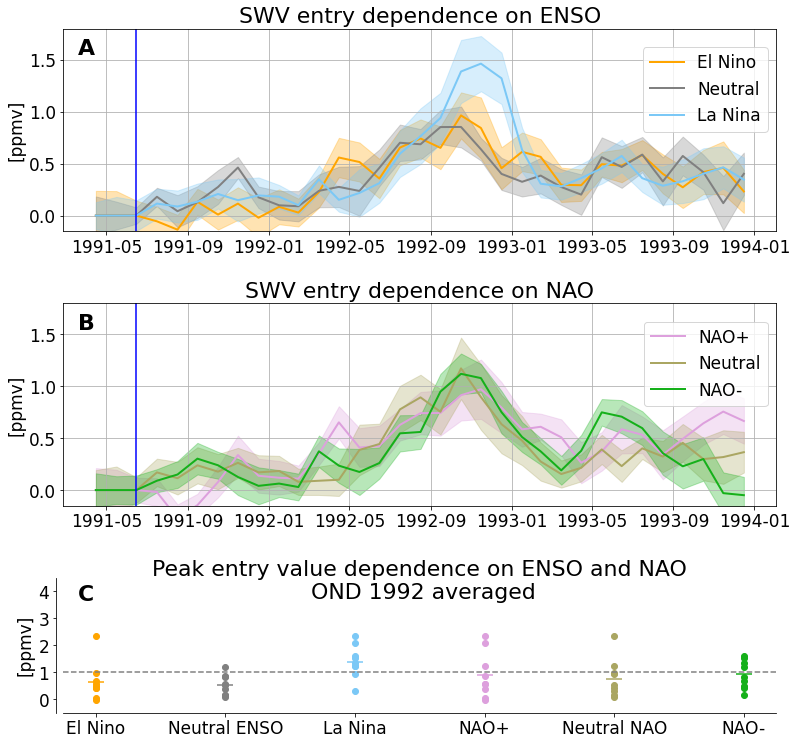

In [3]:
#---------------------------------------------------------
pathMyDirectory='/nfs/b0140/Users/earxzho/VOLMIP/data'
os.chdir(pathMyDirectory)

colorsP=['orange','green','grey','red','purple','grey']
start=0
end=36

cptt=xr.open_dataset(pathMyDirectory+"/temp_cptt_tropics5_control_monthly.nc").temp
cpRH=xr.open_dataset(pathMyDirectory+"/q_tropics_ens_control_monthly.nc").q.sel(plev=100)
cptt_vol=xr.open_dataset(pathMyDirectory+"/temp_cptt_tropics5_volmip_monthly.nc").temp
cpRH_vol=xr.open_dataset(pathMyDirectory+"/q_tropics_ens_volmip_monthly.nc").q.sel(plev=100)


niceDates=[]
for i in range(np.shape(cptt.time)[0]):
    niceDates.append(datetime.date(int(str(cptt.time.values[i])[0:4]),int(str(cptt.time.values[i])[5:7]),int(str(cptt.time.values[i])[8:10])))
# %%
# Ensemble for +NAO/0NAO/-NAO
cptt_naop = (cptt_vol - cptt).isel(realization=slice(0,9))
cptt_nao0 = (cptt_vol - cptt).isel(realization=slice(9,18))
cptt_naon = (cptt_vol - cptt).isel(realization=slice(18,27))

cpRH_naop = (cpRH_vol - cpRH).isel(realization=slice(0,9))
cpRH_nao0 = (cpRH_vol - cpRH).isel(realization=slice(9,18))
cpRH_naon = (cpRH_vol - cpRH).isel(realization=slice(18,27))

N=9
error_naop = error_delta(cptt.isel(realization=slice(0,9)),cptt_vol.isel(realization=slice(0,9)),N)
error_nao0 = error_delta(cptt.isel(realization=slice(9,18)),cptt_vol.isel(realization=slice(9,18)),N)
error_naon = error_delta(cptt.isel(realization=slice(18,27)),cptt_vol.isel(realization=slice(18,27)),N)

errorQ_naop = error_delta(cpRH.isel(realization=slice(0,9)),cpRH_vol.isel(realization=slice(0,9)),N)
errorQ_nao0 = error_delta(cpRH.isel(realization=slice(9,18)),cpRH_vol.isel(realization=slice(9,18)),N)
errorQ_naon = error_delta(cpRH.isel(realization=slice(18,27)),cpRH_vol.isel(realization=slice(18,27)),N)
# %%
list_enso = np.array_split(np.arange(27),9)
i_ensop = np.array(list_enso)[0::3,:].flatten()
i_enso0 = np.array(list_enso)[1::3,:].flatten()
i_enson = np.array(list_enso)[2::3,:].flatten()
cptt_ensop = (cptt_vol - cptt).isel(realization = i_ensop)
cptt_enso0 = (cptt_vol - cptt).isel(realization = i_enso0)
cptt_enson = (cptt_vol - cptt).isel(realization = i_enson)

cpRH_ensop = (cpRH_vol - cpRH).isel(realization = i_ensop)
cpRH_enso0 = (cpRH_vol - cpRH).isel(realization = i_enso0)
cpRH_enson = (cpRH_vol - cpRH).isel(realization = i_enson)

N=9
error_ensop = error_delta(cptt.isel(realization = i_ensop),cptt_vol.isel(realization = i_ensop),N)
error_enso0 = error_delta(cptt.isel(realization = i_enso0),cptt_vol.isel(realization = i_enso0),N)
error_enson = error_delta(cptt.isel(realization = i_enson),cptt_vol.isel(realization = i_enson),N)

errorQ_ensop = error_delta(cpRH.isel(realization = i_ensop),cpRH_vol.isel(realization = i_ensop),N)
errorQ_enso0 = error_delta(cpRH.isel(realization = i_enso0),cpRH_vol.isel(realization = i_enso0),N)
errorQ_enson = error_delta(cpRH.isel(realization = i_enson),cpRH_vol.isel(realization = i_enson),N)

# %%
cptt = []
cptt.append(cptt_ensop.mean('realization')[3:])
cptt.append(cptt_enso0.mean('realization')[3:])
cptt.append(cptt_enson.mean('realization')[3:])
error = []
error.append(error_ensop)
error.append(error_enso0)
error.append(error_enson)
RH = [cpRH_ensop.mean('realization')[3:],cpRH_enso0.mean('realization')[3:],cpRH_enson.mean('realization')[3:]]
RH_error = [errorQ_ensop,errorQ_enso0,errorQ_enson]

label_str = ['El Nino','Neutral','La Nina']

# fig,axes = plot_T_WV_couplet(niceDates[3:],cptt,error_ensop,RH,RH_error,label_str)

# %%
# import matplotlib as mpl

fig,axes=plt.subplots(3,1,figsize=[5,5],gridspec_kw={'height_ratios': [3, 3, 2]})
axes = np.ravel(axes)
plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.4)
# fig.autofmt_xdate()
labelsizes='17'
titlesizes='22'
colors_enso=['#FFA500','#808080','#7BC8F6']
# mpl.style.use('default')
label_enso = ['El Nino','Neutral','La Nina']
for i in range(3):
    axes[0].plot(niceDates[3:],RH[i]*factorQ,linewidth=2.0,label=label_enso[i],color=colors_enso[i])
    axes[0].fill_between(niceDates[3:],  (factorQ*(RH[i]+RH_error[i])), factorQ*((RH[i]-RH_error[i])),alpha=0.3,color=colors_enso[i])

axes[0].set_title('SWV entry dependence on ENSO')#,fontsize=titlesizes)
axes[0].set_ylabel('[ppmv]',fontsize=labelsizes)
axes[0].set_ylim([-0.15,1.8])

RH_nao = [cpRH_naop.mean('realization')[3:],cpRH_nao0.mean('realization')[3:],cpRH_naon.mean('realization')[3:]]
RH_nao_error = [errorQ_naop,errorQ_nao0,errorQ_naon]

colors_nao=['#DDA0DD','#AAA662','#15B01A']
label_nao = ['NAO+','Neutral','NAO-']
for i in range(3):
    axes[1].plot(niceDates[3:],RH_nao[i]*factorQ,linewidth=2.0,label=label_nao[i],color=colors_nao[i])
    axes[1].fill_between(niceDates[3:],  (factorQ*(RH_nao[i]+RH_nao_error[i])), factorQ*((RH_nao[i]-RH_nao_error[i])),alpha=0.3,color=colors_nao[i])

axes[1].set_title('SWV entry dependence on NAO')
axes[1].set_ylabel('[ppmv]',fontsize=labelsizes)
axes[1].set_ylim([-0.15,1.8])
# axes[1].set_xlabel('time',fontsize=labelsizes)

for i in range(0,2):
    axes[i].grid(True)
    axes[i].axvline(x=datetime.date(1991,6,15),color='blue')
    axes[i].tick_params(axis='both', which='major', labelsize=labelsizes)
    # axes[1].set_xlabel('time',fontsize=labelsizes)
    axes[i].set_xlabel('')
    axes[i].legend(fontsize=labelsizes,bbox_to_anchor=(1., 0.7),loc='right',bbox_transform=axes[i].transAxes)
    # axes[i].spines['top'].set_visible(False)
    # axes[i].spines['right'].set_visible(False)

    # axes[0].set_xticks([])
# for i in [0]:
#     axes[i].spines['bottom'].set_visible(False)
#     axes[i].tick_params(axis='x',length=0,labelsize=0) 
#     axes[i].set_xticklabels([])
#-----------------------------
begin=11+12-1 #Oct1992
end=24 #Dec 1992
trans = 0.5
RH_enso_peak = [cpRH_ensop[:,begin:end].mean('time'),cpRH_enso0[:,begin:end].mean('time'),cpRH_enson[:,begin:end].mean('time')]
RH_nao_peak = [cpRH_naop[:,begin:end].mean('time'),cpRH_nao0[:,begin:end].mean('time'),cpRH_naon[:,begin:end].mean('time')]

phase_array = np.ones_like(RH_enso_peak[0])

ax2 = axes[2]
# fig2,ax2 = plt.subplots()
for i in range(3):
    bp = ax2.scatter(phase_array*i,RH_enso_peak[i]*factorQ,color=colors_enso[i],label=label_enso[i])
    ax2.scatter(i,np.mean(RH_enso_peak[i])*factorQ,marker='_',s=250,color=colors_enso[i])

for i in range(3):
    bp = ax2.scatter(phase_array*i+3,RH_nao_peak[i]*factorQ,color=colors_nao[i],label=label_nao[i])
    ax2.scatter(i+3,np.mean(RH_nao_peak[i])*factorQ,marker='_',s=250,color=colors_nao[i])
# ax2.yaxis.grid(True)
ax2.set_ylim([-0.5,4.5])
ax2.set_yticks([0,1,2,3,4])
# Hide the right and top spines
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')

xlabels = label_enso + label_nao
ax2.set_xticks(np.arange(6))
ax2.set_xticklabels(['El Nino','Neutral ENSO','La Nina','NAO+','Neutral NAO','NAO-'],fontsize=labelsizes)
# ax2.legend(fontsize=labelsizes,bbox_to_anchor=[1, 0.8],loc='right')
ax2.set_title('Peak entry value dependence on ENSO and NAO\n OND 1992 averaged',y=0.8)#,fontsize=titlesizes,y=0.8)
ax2.set_ylabel('[ppmv]',fontsize=labelsizes)
ax2.tick_params(axis='both', which='major', labelsize=labelsizes)
ax2.axhline(y=1,color="grey", linestyle="--",zorder=1)

ax2.spines['bottom'].set_position(('axes',-0.001))
ax2.spines['left'].set_position(('axes',-0.01))

for i, label in enumerate(('A', 'B','C')):
    ax = axes[i]
    ax.text(0.02, 0.95, label, transform=ax.transAxes,
            fontsize=titlesizes, fontweight='bold', va='top')

plt.show()
